# Data Configuration

## Import packages & Basic settings

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
!pip install -q tf-nightly

In [3]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.enable_eager_execution()
import os

import numpy as np

import matplotlib.pyplot as plt

keras = tf.keras
tf.VERSION

'1.14.1-dev20190521'

## Data preprocessing

In [4]:
import pathlib
import os

data_root=pathlib.Path('/gdrive/My Drive/img_dataset/beer_dataset/traint/')
print(data_root)

/gdrive/My Drive/img_dataset/beer_dataset/traint


In [5]:
for item in data_root.iterdir():
  print(item)

/gdrive/My Drive/img_dataset/beer_dataset/traint/cass
/gdrive/My Drive/img_dataset/beer_dataset/traint/guinness
/gdrive/My Drive/img_dataset/beer_dataset/traint/tsingtao


In [6]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

img_count = len(all_image_paths)
img_count

936

## Check the images

In [7]:
all_image_paths[:10]

['/gdrive/My Drive/img_dataset/beer_dataset/traint/cass/cass (142).png',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/tsingtao/scene00826 (3).jpg',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/guinness/scene00601 (4).jpg',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/cass/scene00841.jpg',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/cass/cass (533).png',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/cass/scene00241.jpg',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/guinness/scene00436 (3).jpg',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/cass/cass (419).png',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/guinness/scene00151.jpg',
 '/gdrive/My Drive/img_dataset/beer_dataset/traint/tsingtao/scene00166 (5).jpg']

In [0]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image : " + ' - '.join(str(image_rel).split('-'))
    

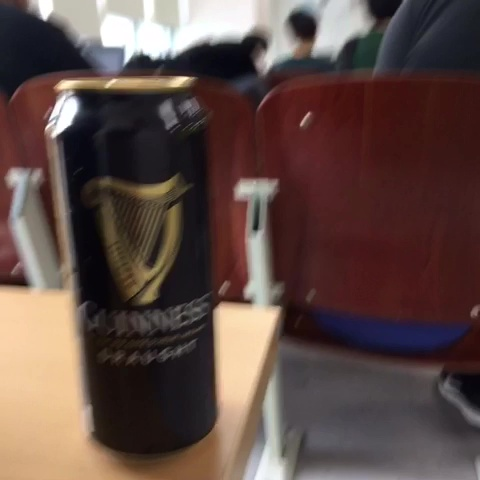

Image : guinness/scene00451 (4).jpg



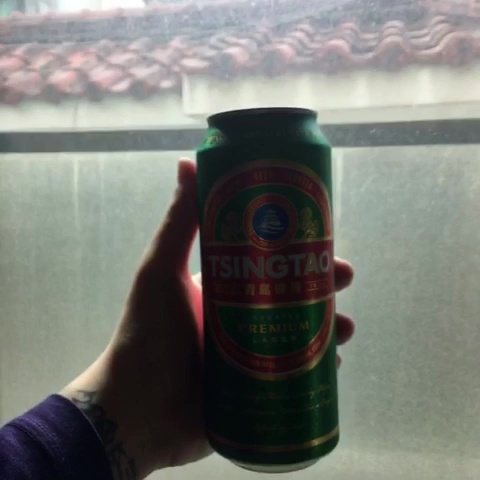

Image : tsingtao/scene00856 (3).jpg



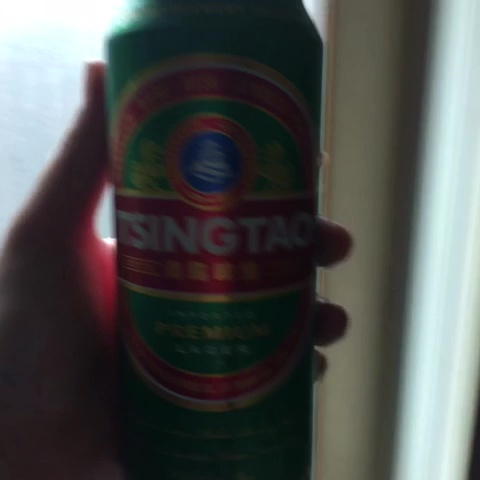

Image : tsingtao/scene00811 (3).jpg



In [9]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

In [10]:
label_names= sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['cass', 'guinness', 'tsingtao']

In [11]:
label_to_index = dict((name,index)for index,name in enumerate(label_names))
label_to_index

{'cass': 0, 'guinness': 1, 'tsingtao': 2}

In [12]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                   for path in all_image_paths]

print("First 10 labels indices : ", all_image_labels[:10])

First 10 labels indices :  [0, 2, 1, 0, 0, 0, 1, 0, 1, 2]


In [13]:
img_path = all_image_paths[0]
img_path

'/gdrive/My Drive/img_dataset/beer_dataset/traint/cass/cass (142).png'

In [14]:
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xe...


In [15]:
img_tensor =tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(480, 480, 3)
<dtype: 'uint8'>


In [16]:
img_final = tf.image.resize_images(img_tensor, [224, 224])

# cast to float
img_final = tf.cast( 
    img_final,
    tf.float32
)

img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(224, 224, 3)
0.0
1.0


In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize_images(image, [224, 224])
  image /= 255.0  # normalize to [0,1] range

  return image

In [0]:
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

In [0]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [20]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

W0521 12:32:23.018679 140594960680832 deprecation.py:323] From <ipython-input-20-2a9400bc986b>:1: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
W0521 12:32:23.025070 140594960680832 deprecation.py:323] From <ipython-input-20-2a9400bc986b>:2: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.


shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

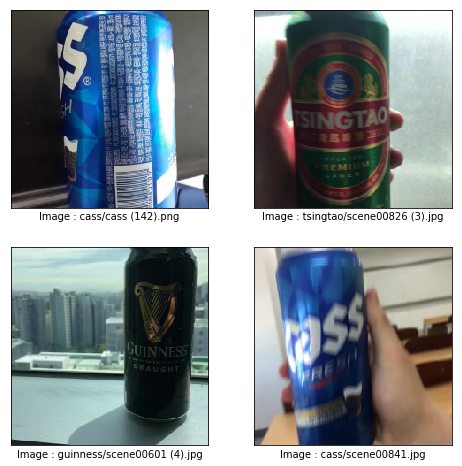

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(caption_image(all_image_paths[n]))

In [0]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [24]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

cass
tsingtao
guinness
cass
cass
cass
guinness
cass
guinness
tsingtao


In [0]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [26]:
print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)

image shape:  (224, 224, 3)
label shape:  ()
types:  (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


## Dataset split

In [0]:
datalen=len(all_image_paths)*0.8

In [0]:
#split data set
train_ds = tf.data.Dataset.from_tensor_slices((all_image_paths[0:int(datalen*0.8)], all_image_labels[0:int(datalen*0.8)]))
val_ds = tf.data.Dataset.from_tensor_slices((all_image_paths[int(datalen*0.8):int(datalen)], all_image_labels[int(datalen*0.8):int(datalen)]))

# The tuples are unpacked into the positional arguments of the mapped function 
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

train_label_ds = train_ds.map(load_and_preprocess_from_path_label)
val_label_ds = train_ds.map(load_and_preprocess_from_path_label)


In [29]:
BATCH_SIZE = 64

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
train_ds = train_ds.shuffle(buffer_size=img_count)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.shuffle(buffer_size=img_count)
val_ds = val_ds.repeat()
val_ds = val_ds.batch(BATCH_SIZE)



# `prefetch` lets the dataset fetch batches, in the background while the model is training.
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print(train_ds)
print(val_ds)

<DatasetV1Adapter shapes: ((?,), (?,)), types: (tf.string, tf.int32)>
<DatasetV1Adapter shapes: ((?,), (?,)), types: (tf.string, tf.int32)>


In [30]:
train_ds=train_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=int(img_count*0.8)))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
print(train_ds)
    
val_ds=val_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=int(img_count*0.2)))
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
print(val_ds)

W0521 12:32:23.865328 140594960680832 deprecation.py:323] From <ipython-input-30-4dd3a0e371f4>:2: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.int32)>


# Train phase

## Model setting

In [0]:
inception_net = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
inception_net.trainable=False

In [0]:
def chage_range(image,label):
    return 2*image-1, label
  
keras_ds =train_ds.map(chage_range)

In [0]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))

In [34]:
feature_map_batch = inception_net(image_batch)
print(feature_map_batch.shape)

(64, 5, 5, 2048)


In [0]:
model = tf.keras.Sequential([
  inception_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

In [36]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: -1.585339
max logit: 2.4045618

Shape: (64, 3)


## Optimizer setting

In [0]:
model.compile(optimizer=tf.train.RMSPropOptimizer(learning_rate=0.001), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [38]:
len(model.trainable_variables) 

2

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [40]:
steps_per_epoch=tf.ceil(int(len(all_image_paths)*0.8)/BATCH_SIZE).numpy()
val_step=tf.ceil(int(len(all_image_paths)*0.2)/BATCH_SIZE).numpy()

print(steps_per_epoch)
initial_epochs=10

12.0


In [41]:
checkpoint_path= '/gdrive/My Drive/checkpoints/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    period=1)

W0521 12:33:44.300655 140594960680832 callbacks.py:875] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [42]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [cp_callback],
                    validation_data=val_ds,
                    validation_steps=val_step,
                    )

Epoch 1/10


W0521 12:33:51.494862 140594960680832 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


11/12 [==========================>...] - ETA: 11s - loss: 2.3121 - acc: 0.4759
Epoch 00001: saving model to /gdrive/My Drive/checkpoints/cp-0001.ckpt
12/12 [==============================] - 163s 14s/step - loss: 2.2085 - acc: 0.4818 - val_loss: 1.0896 - val_acc: 0.4375
Epoch 2/10
11/12 [==========================>...] - ETA: 9s - loss: 1.0392 - acc: 0.5753 
Epoch 00002: saving model to /gdrive/My Drive/checkpoints/cp-0002.ckpt
12/12 [==============================] - 147s 12s/step - loss: 1.0384 - acc: 0.5703 - val_loss: 1.0758 - val_acc: 0.5052
Epoch 3/10
11/12 [==========================>...] - ETA: 9s - loss: 1.0337 - acc: 0.5625 
Epoch 00003: saving model to /gdrive/My Drive/checkpoints/cp-0003.ckpt
12/12 [==============================] - 148s 12s/step - loss: 1.0254 - acc: 0.5742 - val_loss: 1.0639 - val_acc: 0.5469
Epoch 4/10
11/12 [==========================>...] - ETA: 9s - loss: 0.8722 - acc: 0.5980 
Epoch 00004: saving model to /gdrive/My Drive/checkpoints/cp-0004.ckpt
12/1

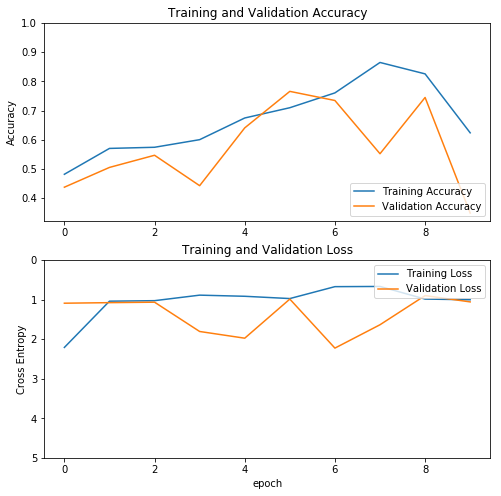

In [43]:
acc = history.history["acc"]
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([5,0.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [58]:
loss, acc = model.evaluate(val_ds,steps=val_step)
print("val 정확도: {:5.2f}%".format(100*acc))

3/3 [==============================] - 27s 9s/step - loss: 1.5748 - acc: 0.3385
val 정확도: 33.85%


In [0]:
checkpoint_path = '/gdrive/My Drive/checkpoints/v1/cp-0009.ckpt'

In [79]:
model.load_weights(checkpoint_path)
loss,acc = model.evaluate(val_ds, steps=val_step)
print("복원된 모델의 validation 정확도: {:5.2f}%".format(100*acc))

3/3 [==============================] - 27s 9s/step - loss: 0.8969 - acc: 0.7448
복원된 모델의 정확도: 74.48%


## Finetuning

In [73]:
inception_net.trainable =True
print("Number of layers in the base model :", len(inception_net.layers))

Number of layers in the base model : 311


In [0]:
fine_tune_at = 300

for layer in inception_net.layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0001), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [76]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,659
Non-trainable params: 21,802,272
_________________________________________________________________


In [77]:
len(model.trainable_variables)

4

In [78]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                    epochs=total_epochs,
                    initial_epoch=initial_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds,
                    validation_steps=val_step,
                    )

Epoch 11/15
12/12 [==============================] - 153s 13s/step - loss: nan - acc: 0.6146 - val_loss: nan - val_acc: 0.5312
Epoch 12/15


KeyboardInterrupt: ignored

In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

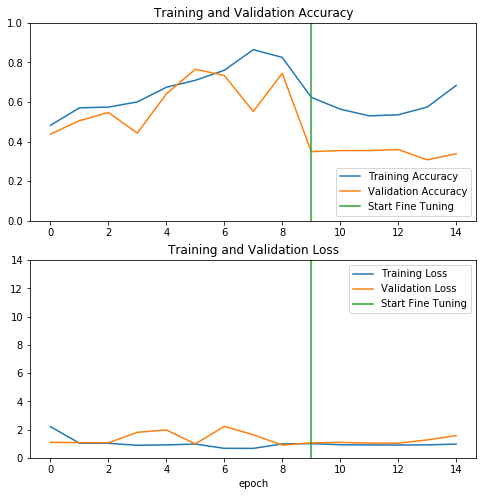

In [51]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 14])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Save Phase

## Save tflite file

In [0]:
pth = '/gdrive/My Drive/checkpoints/'

In [93]:
h5_file = pth+"lienar.h5"
keras.models.save_model(model,h5_file)

Converter = tf.lite.TFLiteConverter.from_keras_model_file(h5_file)
tflite_model = Converter.convert()
open(pth+"linear_ver2.tflite","wb").write(tflite_model)

W0521 13:53:04.246064 140594960680832 hdf5_format.py:110] TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file. You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
W0521 13:53:09.439804 140594960680832 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


87144384

## Load Check

In [103]:
new_model = keras.models.load_model(h5_file)
new_model.summary()

W0521 14:01:29.755727 140594960680832 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,659
Non-trainable params: 21,802,272
_________________________________________________________________


In [0]:
new_model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0001), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [105]:
loss,acc = new_model.evaluate(val_ds, steps=val_step)
print("복원된 모델의 validation 정확도: {:5.2f}%".format(100*acc))

3/3 [==============================] - 25s 8s/step - loss: 0.8969 - acc: 0.7448
복원된 모델의 validation 정확도: 74.48%
